In [2]:
import torch
import matplotlib.pyplot as plt
import os
import sys
import warnings
# module_path = os.path.abspath(os.path.join('TF_net'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
from train import Dataset, train_epoch, eval_epoch, test_epoch, Scaler, preprocess
import torch.nn as nn
from torch.utils import data
from scipy import stats
from pathlib import Path
import numpy as np

class Args:
    pass

In [3]:
args = Args() 
args.data = 'data5.pt'


if args.data == "rbc_data.pt":
    compress = True
    permute = False
    offset=0
    transform_type = 'std'
elif args.data == 'data5.pt':
    compress = False
    permute = True
    offset = 20
    transform_type = 'none'
else:
    raise ValueError("Un expected data file name")
args.transform = Scaler(transform_type, offset)

if Path(args.data).name == args.data: args.data = "../" + args.data

data_prep = preprocess(args, permute, compress, test_mode=True)

tensor([0])
tensor([1]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7f760b5cfb80> <function Scaler.fit_transform.<locals>.<lambda> at 0x7f760b5cfb80>


In [6]:
stats.describe(data_prep,None)

DescribeResult(nobs=113541120, minmax=(-8.89901, 13.12748), mean=2.575439e-07, variance=0.024671673992012092, skewness=6.750569851671229, kurtosis=210.45958579253136)

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def norm_each_sample(x):
    x = torch.clone(x)
    _max= torch.amax(x, dim=(2, 3), keepdim=True) 
    _min= torch.amin(x, dim=(2, 3), keepdim=True) 
    return (x - _min) / (_max - _min)

def plot(video, channel, frames = None):
    if frames is None:
        frames = video.shape[0]
    warnings.warn("Going to normalize each sample for visualizing purpose")
    video = norm_each_sample(video)
    fig = plt.figure()
    im = plt.imshow(video[0,channel,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[0,channel,:,:])

    def animate(i):
        im.set_data(video[i,channel,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames,
                                interval=50)
    return anim.to_html5_video()

HTML(plot(data_prep, 0, 120))

In [10]:
test_indices = list(range(7700, 9800))
input_length = 26
time_range = 6
batch_size = 21
device = "cuda:"
device_ids = [0]
args.path = "../results/tfnet_data5/tfnet_data5_17/"
kernel_size=3
dropout_rate=0

device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")
loss_fun = torch.nn.MSELoss()

best_model = nn.DataParallel(torch.load(args.path+"model.pth", map_location=device).module, device_ids=device_ids)
data_prep = preprocess(args, permute, compress, test_mode=True)

print("Testing in test setting")
test_set = Dataset(test_indices, input_length + time_range - 1, 40, 60, data_prep, True,test_mode=True)
test_loader = data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 8)
preds, trues, loss_curve = test_epoch(args, test_loader, best_model, loss_fun, test_mode=True, save_preds= True, device=device)

torch.save({"loss_curve": loss_curve}, 
            args.path+"results.pt",pickle_protocol=5)

tensor([-224.2000])
tensor([723.7476])
Testing in test setting


100%|██████████| 100/100 [05:13<00:00,  3.13s/it]


[  9.97290302  12.86470118  16.74928582  21.63886605  27.54688664
  33.61468235  40.38044915  47.5646394   55.15632573  62.84734058
  70.70428264  78.6822426   86.52786642  94.34937728 101.90685892
 109.27709244 116.60971068 123.80416122 130.93224949 137.76425323
 144.27707544 150.55299843 156.69715447 162.46267392 168.00151007
 173.13758567 178.1026666  182.69243517 187.04593952 191.13649116
 195.01357397 198.67421222 202.09685938 205.26503116 208.24733424
 211.00539487 213.55587597 215.93249581 218.15933399 220.24912385
 222.24225208 224.13154777 225.95251366 227.68283485 229.35349187
 230.96970237 232.52352105 234.01267674 235.46013051 236.87485226
 238.27764581 239.65317823 241.03327061 242.4246633  243.82875865
 245.24731134 246.69272808 248.16785981 249.67108994 251.20191823]


In [11]:
preds.shape
trues.shape

(2100, 60, 2, 64, 448)

In [12]:
ndx = 20
ones = 0.1*np.ones_like(preds[ndx])
obs = np.concatenate((preds[ndx], ones, trues[ndx]),axis=2)
HTML(plot(torch.from_numpy(obs), 0))

In [17]:
HTML(plot(torch.from_numpy(preds[ndx]), 0))

In [21]:
print(stats.describe(preds, None))
print(stats.describe(trues, None))

(array([[ 0.,  0.,  7., ...,  0.,  0.,  0.],
        [ 0.,  0.,  7., ...,  0.,  0.,  0.],
        [ 0.,  0.,  7., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  9., 10., 11.],
        [ 0.,  0.,  0., ...,  9., 10., 11.],
        [ 0.,  0.,  0., ..., 10., 10., 11.]]),
 array([0.30961025, 0.30964309, 0.30967593, 0.3097088 , 0.30974165,
        0.30977449, 0.30980733, 0.30984017, 0.30987304, 0.30990589,
        0.30993873]),
 <a list of 448 BarContainer objects>)

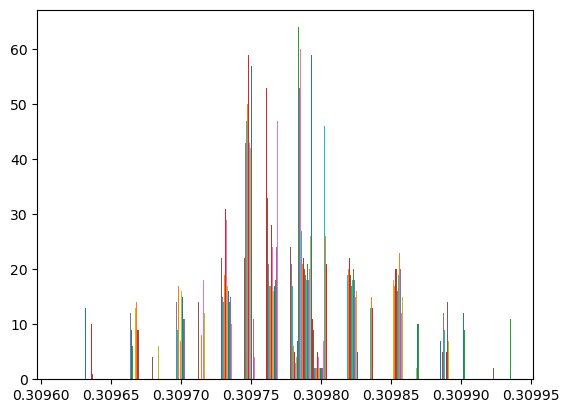

In [19]:
plt.hist(trues[ndx,0,0])

In [ ]:
! We loose details over long horizon.